# Neural Network Specifics:
- We're defining a feed-forawrd NN with four layers (input layer, two hidden layers, and output layer).
- Input layer is each of the 784 grayscale values
- The hidden layers will have sixteen neurons each.
- Activation functions of hidden layer neurons will be the ReLU
- There will be 10 output layer neurons, representing the computed probability of the digit the input image represents.
- Activation functions of the output layer will be softmax
- We'll use cross entropy as the loss function

Import packages

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load Dataset

In [4]:
dataset_train = pd.read_csv("mnist_train.csv").to_numpy()

Initialise weight matrices and bias vectors using random normal distrubution

In [65]:
class Layer:
    z=0
    a=0
    def __init__(self, dimensions):
        self.weights=np.random.normal(loc=0,scale=0.01,size=dimensions)
        self.biases=np.random.normal(loc=0, scale=0.01, size=dimensions[1])

#Layer 1
l1=Layer((784,16))

#Layer 2
l2=Layer((16,16))

#Layer 3
l3=Layer((16,10))

Define Activation functions

In [66]:
def ReLU(x):
    return np.maximum(x,0)

def softmax(x):
    m=np.max(x)
    return np.exp(x-m)/np.exp(x-m).sum()

Implement Forward Propagation

In [67]:
def forward_prop(training_data):
    l1.z=np.dot(training_data[1:],l1.weights)+l1.biases
    l1.a=ReLU(l1.z)

    l2.z=np.dot(l1.z, l2.weights)+l2.biases
    l2.a=ReLU(l2.z)

    l3.z=np.dot(l2.z, l3.weights)+l3.biases
    l3.a=softmax(l3.z)
    return l1, l2, l3

One-hot encoding

In [68]:
def one_hot(training_data):
    y=np.zeros(10)
    index=training_data[0]
    y[index]=1
    return y

Implement cross-entropy loss


In [69]:
def ce_loss(training_data, predictions):
    epsilon = 1e-10
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    y=one_hot(training_data)
    ce= -np.mean(np.log(predictions)*y)
    return ce

Define backpropagation

In [70]:
def dReLU(z):
    return z>0

def backword_prop(training_data, l1,l2,l3,y):
    dZ3=l3.a-y
    dZ2=np.dot(l3.weights, l3.a-y) * dReLU(l2.z)
    dZ1=np.dot(l2.weights, dZ2) * dReLU(l1.z)
    dW3 = np.outer(l2.a, dZ3)
    dW2 = np.outer(l1.a, dZ2)
    dW1 = np.outer(training_data[1:], dZ1)
    dB1 = dZ1
    dB2=dZ2
    dB3= dZ3

    return dW1, dW2, dW3, dB1, dB2, dB3


Training

In [80]:
learning_rate=0.01
epochs=1000
for epoch in range(epochs):
    np.random.shuffle(dataset_train)
    gradient = {"dW1": np.zeros(l1.weights.shape), 
                "dB1": np.zeros(l1.biases.shape),
                "dW2": np.zeros(l2.weights.shape), 
                "dB2": np.zeros(l2.biases.shape), 
                "dW3": np.zeros(l3.weights.shape), 
                "dB3": np.zeros(l3.biases.shape)}
    loss=0
    for training_data in dataset_train:
        l1,l2,l3=forward_prop(training_data)
        y=one_hot(training_data)
        dW1, dW2, dW3, dB1, dB2, dB3=backword_prop(training_data, l1,l2,l3,y)
        gradient["dW1"]=np.add(gradient["dW1"],dW1)
        gradient["dW2"]=np.add(gradient["dW2"],dW2)
        gradient["dW3"]=np.add(gradient["dW3"],dW3)

        gradient["dB1"]=np.add(gradient["dB1"],dB1)
        gradient["dB2"]=np.add(gradient["dB2"],dB2)
        gradient["dB3"]=np.add(gradient["dB3"],dB3)
        loss+=ce_loss(training_data, l3.a)

    for array in gradient.values():
        array/=dataset_train.shape[0]
    loss
    l1.weights -= learning_rate * gradient["dW1"]
    l1.biases -= learning_rate * gradient["dB1"]
    l2.weights -= learning_rate * gradient["dW2"]
    l2.biases -= learning_rate * gradient["dB2"]
    l3.weights -= learning_rate * gradient["dW3"]
    l3.biases -= learning_rate * gradient["dB3"]
    
    print("Epoch: %d, Loss: %d"%(epoch, loss))


Epoch: 0, Loss: 2409
Epoch: 1, Loss: 2409


KeyboardInterrupt: 

Run custom tests:

input:


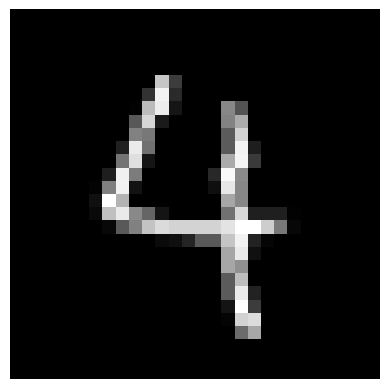

Predicted value:  4


In [126]:
index=24
dataset_test = pd.read_csv("mnist_test.csv").to_numpy()
plt.imshow(dataset_test[index][1:].reshape(28,28),cmap="gray")
l1,l2,l3 = forward_prop(dataset_test[index])
print("input:")
plt.axis('off')
plt.show()
print("Predicted value: ",np.argmax(l3.a))



Determine sucess rate

In [118]:
sucesses=0
for test_data in dataset_test:
    l1,l2,l3 = forward_prop(test_data)
    if np.argmax(l3.a)==test_data[0]:
        sucesses+=1
print(sucesses/dataset_test.shape[0]*100)

90.06


In [ ]:
np.savetxt("model-parameters/layer1-weights.csv", l1.weights, delimiter=',')
np.savetxt("model-parameters/layer2-weights.csv", l2.weights, delimiter=',')
np.savetxt("model-parameters/layer3-weights.csv", l3.weights, delimiter=',')
np.savetxt("model-parameters/layer1-biases.csv", l1.biases, delimiter=',')
np.savetxt("model-parameters/layer2-biases.csv", l2.biases, delimiter=',')
np.savetxt("model-parameters/layer3-biases.csv", l3.biases, delimiter=',')